## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as im
import pickle
%matplotlib inline


### Compute the camera calibration using chessboard images

In [2]:
# Object points
objp        = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob("camera_cal/*.jpg")

for idx, filename in enumerate(images):
    # Read image
    image = im.imread(filename)
    # Convert to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Find image points
    isFound, points = cv2.findChessboardCorners(gray, (9,6), None)
    
    # Check if we found an image
    if isFound == True:
        objpoints.append(objp)
        imgpoints.append(points)
        
        # Draw point on the image
        cv2.drawChessboardCorners(image, (8,6), points, isFound)
        
        # Plot image
        cv2.imshow('image', image)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

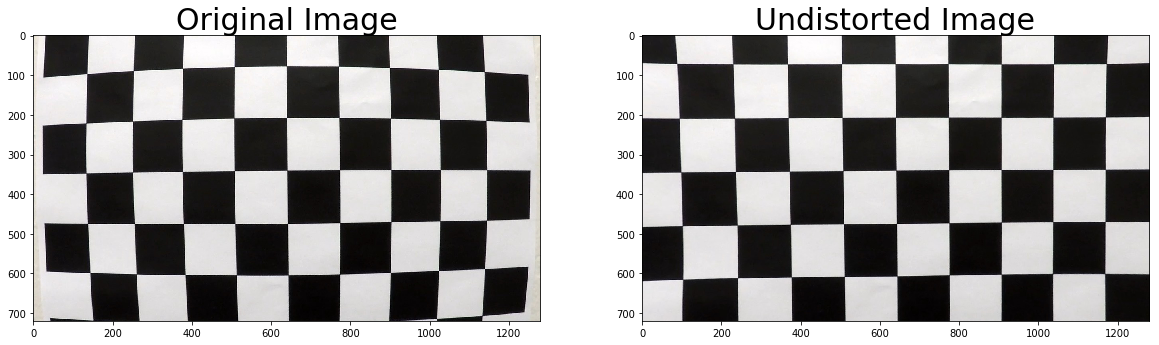

In [3]:
# Read test image
image = im.imread("camera_cal/calibration1.jpg")
size  = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)

dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal//wide_dist_pickle.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply a distortion correction to raw images

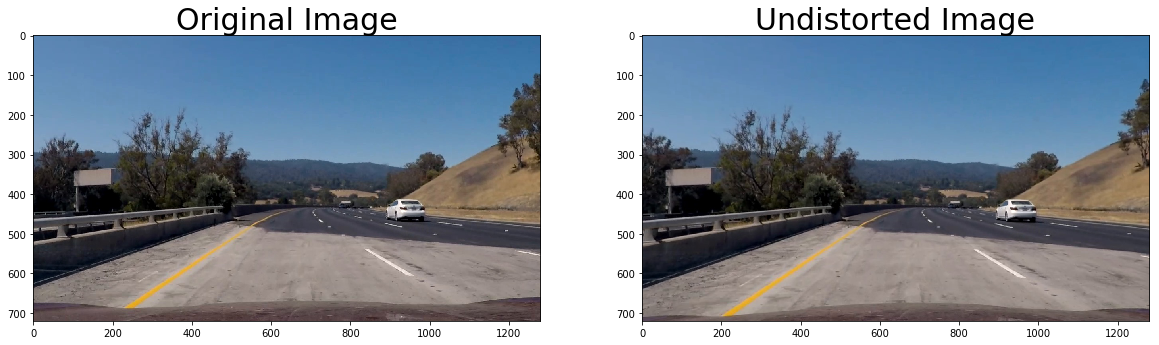

In [168]:
image = im.imread("./frame_608.jpg")
und_image =  cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_image)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image


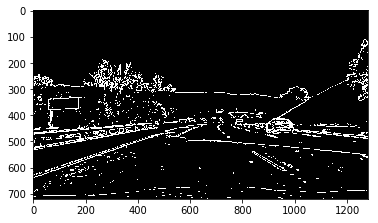

In [169]:
# Gray scale
gray = cv2.cvtColor(und_image, cv2.COLOR_RGB2HLS)[:,:,1]
# Take gradint x direction
sobelx = cv2.Sobel(gray, cv2.CV_64F,1, 0)
sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
# ABS value
abs_sobel = np.sqrt(sobelx**2 + sobely**2)
# scale gradint
scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))

thresh_max = 180
thresh_min = 26
sxbinary   = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')
plt.imshow(sxbinary, cmap='gray')

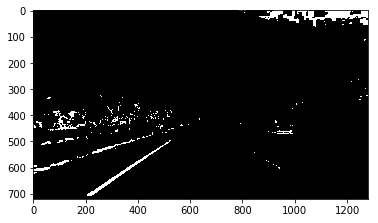

In [207]:
thresh = (120,255)
HLS    = cv2.cvtColor(und_image, cv2.COLOR_RGB2HLS)
H      = HLS[:,:,0]
L      = HLS[:,:,1]
S      = HLS[:,:,2]
binary = np.zeros_like(H)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary, cmap='gray')


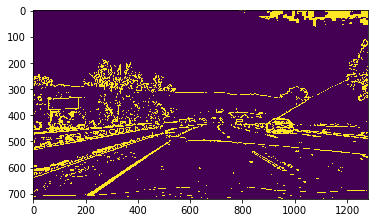

In [208]:
combined_binary = np.zeros_like(binary)
combined_binary[(binary==1) | (sxbinary==1)] = 1
plt.imshow(combined_binary)

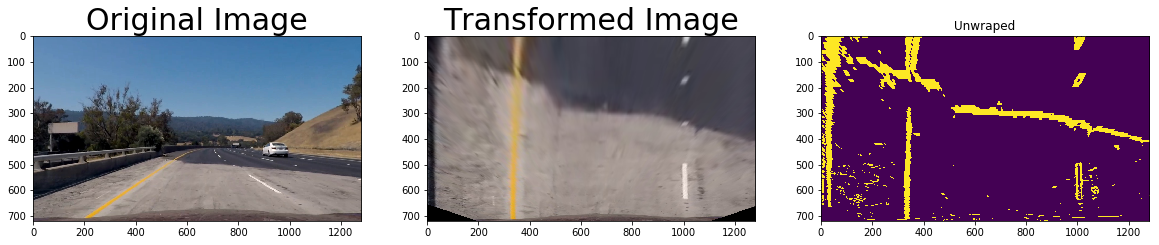

In [209]:
#image = im.imread("./test_images/test3.jpg")
#und_image =  cv2.undistort(image, mtx, dist, None, mtx)

src = np.float32([[(215, 720), (565, 470), (720, 470), (1105, 720)]])
dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

# 1. Get transormation matrix
M    = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# 2. Compute the inverse perspective transform
binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
warped        = cv2.warpPerspective(und_image, M, (und_image.shape[1], und_image.shape[0]), flags=cv2.INTER_LINEAR)
unwraped      = cv2.warpPerspective(warped, Minv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)

#cv2.line(und_image,(215, 720),(565, 470),(255,0,0),5)
#cv2.line(und_image,(565, 470),(720, 470),(255,0,0),5)
#cv2.line(und_image,(720, 470),(1105, 720),(255,0,0),5)

#cv2.line(wraped,(350, 720),(350, 0),(255,0,0),5)
#cv2.line(wraped,(350, 0),(980, 0),(255,0,0),5)
#cv2.line(wraped,(980, 0),(980, 720),(255,0,0),5)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(und_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=30)
ax3.imshow(binary_warped)
ax3.set_title('Unwraped')

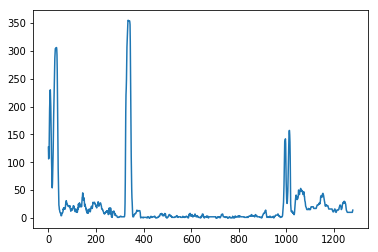

In [210]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [211]:
# Output image
output = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
# Find left and right peak
midpoint = np.int(histogram.shape[0]/2) # Mid point
left_base= np.argmax(histogram[:midpoint])
right_base= np.argmax(histogram[midpoint:]) + midpoint

# Number of windows
nwindows = 9
# Height of window
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x, y points of all . onseros pixls
nonzero  = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions of all none zeros pixels
left_current  = left_base
right_current = right_base
# Set width of window +/- margin
margin = 100
# set number of pixels found to recenter window
minpix = 50

left_lane_inds  = []
right_lane_inds = []

for window in range(nwindows):
    # identify window boundaries x/y and Left/Right
    win_y_low       = binary_warped.shape[0] - (window+1)*window_height
    win_y_high      = binary_warped.shape[0] - window*window_height
    win_xleft_low   = left_current - margin
    win_xleft_high  = left_current + margin
    win_xright_low  = right_current - margin
    win_xright_high = right_current + margin
    # Draw window in the output image
    cv2.rectangle(output, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
    cv2.rectangle(output, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append new indices
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        left_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        right_current= np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds  = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit= np.polyfit(righty, rightx, 2)

(720, 0)

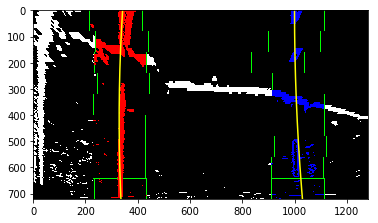

In [212]:
ploty      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx  = left_fit[0] * ploty**2+left_fit[1]*ploty+left_fit[2]
right_fitx = right_fit[0] * ploty**2+right_fit[1]*ploty+right_fit[2]

output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]]   = [255,0,0]
output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
plt.imshow(output)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

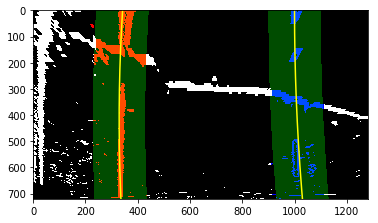

In [213]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [214]:
#  Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

6690.16254108 8620.37467128


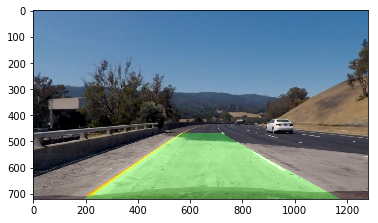

In [215]:

plt.imshow(warped)
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (und_image.shape[1], und_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(und_image, 1, newwarp, 0.3, 0)
plt.imshow(result)